# Statistical and systematic uncertainties in fitting

Originally developed by William Irvine for PHYS 211 (January 2016)

## Introduction 

This program generates mock data sets given a model, with adjustable statistical and systematic uncertainties.

The purpose is to both quantitiatively and graphically represent the effects of statistical and systematic uncertainties on a linear fit to data. This is accomplished by generating a pseudodata dataset that is assigned both statistical and systematic uncertainties. 

## Preliminaries

Import the appropriate libraries and define a few helper methods that provide linear functions and their residuals.

In [1]:
import numpy as np
from scipy import loadtxt, optimize
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
# simple linear function
def linear(p, x):
    """
    Creates a simple linear function
    
    Parameters
    ----------
    p: array of parameters
      p[0] is the y-intercept
      p[1] is the slope
    
    x: array of x-values at which to 
       evaluate the linear function
    """
    
    return p[0] + p[1]*x

In [3]:
# residual of a linear function 
def linear_residual(p, x, y, dy):
    """
    Computes the residuals for a simple linear function
    
    Parameters
    ----------
    p: array of parameters
      p[0] is the y-intercept
      p[1] is the slope
    
    x: array of x-values at which to 
       evaluate the linear function
       
    y: array of observed y-values
    
    dy: uncertainties on the observed y-values
    """
    
    return (linear(p,x)-y)/dy

In [4]:
# gaussian function
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [5]:
# values drawn from gaussian distribution
def gdist(N=100, mean=0, sigma=5):
    return sigma*np.random.randn(N)+mean

In [6]:
# generate a mock dataset: function func evaluated at x-values x, with standard deviations sigma 
def mockdata(x, sigma, func):
    """
    Generates a pseudodata dataset of y-values distributed according 
    to a Gaussian distribution, with a mean value given by evaluating 
    the function `func` at the corresponding x-values, `x`, and with
    standard deviations `sigma`.
    
    Parameters
    ----------
    x: array of x-values at which to 
       evaluate the function provided
      
    sigma: value or array of values of 
           uncertainties on y-values at 
           each x-value specified
       
    func: function that gives the y-value 
          on which to center a Gaussian 
          distribution of possible y-values
    """
    
    # if standard deviation is a single number - that is assigned to all points
    if np.size(sigma)==1:
        sigma = sigma*np.ones_like(x)
    
    # Initialize an array to hold the generated distribution of y-values 
    # based on a probability distribution function func
    yy=[]
    
    # otherwise each point can have a separate sigma
    err=sigma
    
    # loop over all of the x-values and generate a Gaussian distribution 
    # of y-values given by the `gdist` function with standard deviations
    # given by the uncertainty in the y-values specified by `sigma`
    for xi, si in zip(x,sigma):
        yy.append( gdist(N=1, mean=func(xi), sigma=si)[0] )
    
    yy = np.array(yy)
    
    # Return the array of y-values distributed according to a Gaussian 
    # distribution, with a mean value given by evaluating the function
    # `func` at the corresponding x-values
    return yy, err

In [7]:
# x coordinates that specify the measurements
xvalues = np.array([0,2,3,4,5,15,30])

In [8]:
# Systematic uncertainties for each measurement point
systs = 0.0*np.array([1,3,-2,7,-3,2,-5])

In [9]:
# Underlying ("true") standard deviations of values of the measurements at each point `x`
# These are what we will use to generate the distributions of possible measurements
true_error = np.array([2,2,2,3,3,3,3.5])

In [10]:
# Estimated errors (could be the same as the true errors, or not)
estimated_error = 1.0*true_error

In [11]:
# Specify the "true" model. That is, we define the y-intercept (p0[0]) and slope (p0[1]) of our linear system 
p0 = [2,3.3]

In [12]:
# Create a lambda function for handing to the mockdata
func = lambda x: linear(p0, x)
func_residual = linear_residual

In [13]:
def plottruemodel(xarray, ax):
    # plot the perfect line
    ax.plot(xarray, func(xarray), '-', color='gray', alpha=0.3, label = 'True model')
    
    return ax

In [14]:
# Create the figure and its axes that we'll use throughout the plotting
def make_my_figure(xmax=35, ymax=120): 
    
    fig = plt.figure()

    fig.patch.set_facecolor('w')

    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75]) 
    ax.set_title('Some Sample Data with Error Bars')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([0,xmax])
    ax.set_ylim([0,ymax])
    
    return fig, ax

In [15]:
# This gives us an array of x-values to plot the line
xarray = np.arange(0,35)

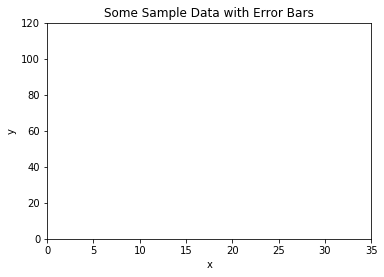

In [16]:
# Create figure and axes so that they can be reused
fig, ax = make_my_figure()

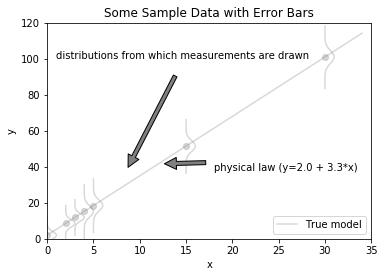

In [17]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the perfect line
ax = plottruemodel(xarray, ax)

# Annotate the plot to indicate what it is that we've drawn
ax.annotate('physical law (y=%.1f + %.1f*x)' % (p0[0], p0[1]), 
            xy=(12, func(12)), xytext=(18, 38), 
            arrowprops=dict(facecolor='gray', shrink=0.11))

ax.annotate('distributions from which measurements are drawn', 
            xy=(8, func(8)+4), xytext=(1, 100), 
            arrowprops=dict(facecolor='gray', shrink=0.11))

# plot the pdfs of the underlying data
for xi,tei in zip(xvalues, true_error):
    yi = func(xi)
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    newxarray = xi+gauss(yyy,yi,tei,1)
    ax.plot(newxarray,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3, label = '')

    
# Position the legend
ax.legend(loc=4)

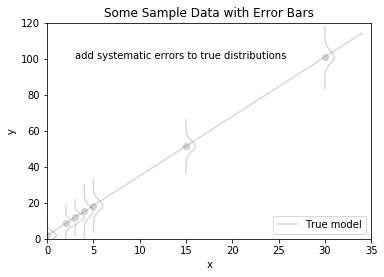

In [18]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Annotate the plot
ax.text(3,100,'add systematic errors to true distributions')

# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yo = func(xi)
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3, label='')
    ax.annotate('', xy=(xi,yi), xytext=(xi, yo), 
    arrowprops=dict(facecolor='green',arrowstyle="->")) 
    

# Position the legend
ax.legend(loc=4)

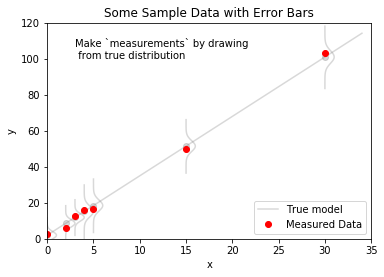

In [19]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Generate some pseudodata according to the true underlying PDF
yvalues, ee     = mockdata(xvalues, true_error, func)
yvalues_nominal = yvalues
yvalues_syst    = yvalues + systs

ax.text(3,100,'Make `measurements` by drawing\n from true distribution')
    
# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yo = func(xi)
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3, label='')

l2 = ax.plot(xvalues, yvalues_syst, 'ro', label = 'Measured Data')
    
# Position the legend
ax.legend(loc=4)

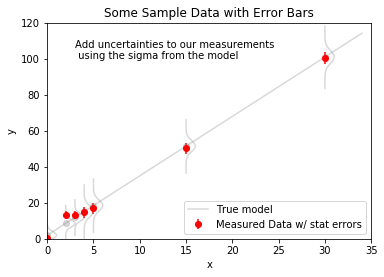

In [20]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Generate some pseudodata according to the true underlying PDF
yvalues, ee     = mockdata(xvalues, true_error, func)
yvalues_nominal = yvalues
yvalues_syst    = yvalues + systs

ax.text(3,100,'Add uncertainties to our measurements\n using the sigma from the model')
    
# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yo = func(xi)
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3)

l2 = ax.errorbar(xvalues, yvalues_syst, ee, fmt='ro', label = 'Measured Data w/ stat errors')
 
ax.legend(loc=4)    
    
#display.clear_output(wait=True)
#display.display(fig)

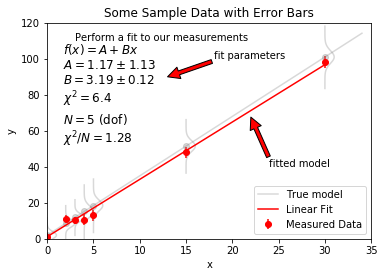

In [21]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Generate some pseudodata according to the true underlying PDF
yvalues, ee     = mockdata(xvalues, true_error, func)
yvalues_nominal = yvalues
yvalues_syst    = yvalues + systs

ax.text(3, 110, 'Perform a fit to our measurements')

# Perform the fit to our pseudodata
fitparams, cov, info, mesg, success = optimize.leastsq(func_residual, p0, args=(xvalues, yvalues_syst, estimated_error), full_output=1)
chisq = sum(info["fvec"]*info["fvec"])
dof   = len(xvalues)-len(fitparams)

# Put the fit errors 
fitparamerr = []
for i in range(len(fitparams)):
    fitparamerr.append(np.sqrt(cov[i,i]))

# text for reporting fit paramaters
textfit = '$f(x) = A + Bx$ \n' \
          '$A = %.2f \pm %.2f$ \n' \
          '$B = %.2f \pm %.2f$ \n' \
          '$\chi^2= %.1f$ \n' \
          '$N = %i$ (dof) \n' \
          '$\chi^2/N = % .2f$' \
             % (fitparams[0], fitparamerr[0], fitparams[1], fitparamerr[1],
                chisq, dof, chisq/dof)

# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3)


#plot fitted line
l3 = ax.plot(xvalues, linear(fitparams, xvalues), 'r-', label = 'Linear Fit')

ax.annotate('fitted model', xy=(22, func(22)-7), xytext=(24, 40), 
        arrowprops=dict(facecolor='red', shrink=0.))

ax.annotate('fit parameters', xy=(13,90), xytext=(18, 100), 
        arrowprops=dict(facecolor='red', shrink=0.))

ax.text(0.05, .90, textfit, transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Now let's plot the data and the fit at the same time
#l1 = ax.errorbar(xvalues, yy0, ee, fmt='ko', label = 'Unbiased Data',alpha=0.3)
l2 = ax.errorbar(xvalues, yvalues_syst, estimated_error, fmt='ro', label = 'Measured Data')

ax.legend(loc=4)   

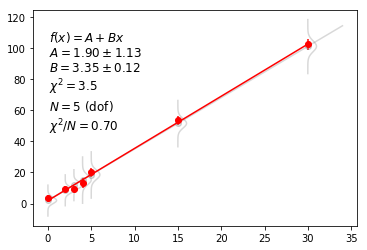

In [31]:
# Build the canvas again
fig, ax = make_my_figure()

# initialize array for collecting results of fits
results=[]

# generate 200 different fits
for rr in 1+np.arange(1000):

    plt.cla()
    
    # plot the true model
    ax = plottruemodel(xarray, ax)   

    # Generate some pseudodata according to the true underlying PDF
    yvalues, ee     = mockdata(xvalues, true_error, func)
    yvalues_nominal = yvalues
    yvalues_syst    = yvalues + systs

    # Perform the fit to our pseudodata
    fitparams, cov, info, mesg, success = optimize.leastsq(func_residual, p0, args=(xvalues, yvalues_syst, estimated_error), full_output=1)
    chisq = sum(info["fvec"]*info["fvec"])
    dof   = len(xvalues)-len(fitparams)

    # Put the fit errors 
    fitparamerr = []
    for i in range(len(fitparams)):
        fitparamerr.append(np.sqrt(cov[i,i]))

    # text for reporting fit paramaters
    textfit = '$f(x) = A + Bx$ \n' \
              '$A = %.2f \pm %.2f$ \n' \
              '$B = %.2f \pm %.2f$ \n' \
              '$\chi^2= %.1f$ \n' \
              '$N = %i$ (dof) \n' \
              '$\chi^2/N = % .2f$' \
                 % (fitparams[0], fitparamerr[0], fitparams[1], fitparamerr[1],
                    chisq, dof, chisq/dof)

    # plot the pdfs of the underlying data
    for xi,tei,ssi in zip(xvalues, true_error, systs):
        yi = func(xi) + ssi
        yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
        xxx = xi+gauss(yyy,yi,tei,1)
        ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
        ax.plot(xi,yi,'o',color='gray',alpha=0.3)

    # Now let's plot the data and the fit at the same time
    #l1 = ax.errorbar(xvalues, yy0, ee, fmt='ko', label = 'Unbiased Data',alpha=0.3)
    l2 = ax.errorbar(xvalues, yvalues_syst, estimated_error, fmt='ro', label = 'Measured Data')


    #plot fitted line
    l3 = ax.plot(xvalues, linear(fitparams, xvalues), 'r-', label = 'Linear Fit')

    #l4 = ax.errorbar(xx+0.1, yy, estimated_error, fmt='gx', label = 'Estimated Error')

    ax.text(0.05, .90, textfit, transform=ax.transAxes, fontsize=12,verticalalignment='top')

    #display.clear_output(wait=True)
    #display.display(fig)

    results.append([chisq/dof, fitparams[0], fitparams[1]])

Text(0, 0.5, 'Relative frequency')

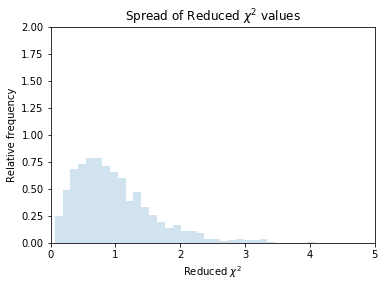

In [38]:
# Build the canvas again
fig, ax = make_my_figure(5,2)

results = np.array(results)


# Histogram the chi-square values
ax.hist(results[:,0], bins=int(np.size(results[:,0])/30), alpha=0.2, density=True)

ax.set_title('Spread of Reduced $\chi^2$ values')
ax.set_xlabel('Reduced $\chi^2$')
ax.set_ylabel('Relative frequency')


Text(0, 0.5, 'Relative frequency')

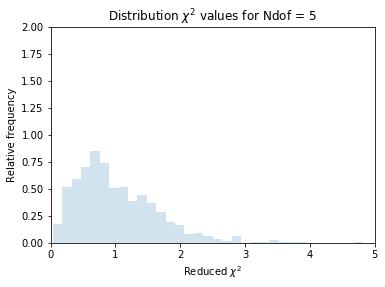

In [39]:
# Build the canvas again
fig, ax = make_my_figure(5,2)

# Histogram the chi-square values
ax.hist(np.random.chisquare(dof,1000)/dof, bins=int(np.size(results[:,0])/30), alpha=0.2, density=True)

ax.set_title('Distribution $\chi^2$ values for Ndof = %d' % dof)
ax.set_xlabel('Reduced $\chi^2$')
ax.set_ylabel('Relative frequency')


Text(0, 0.5, 'Relative frequency')

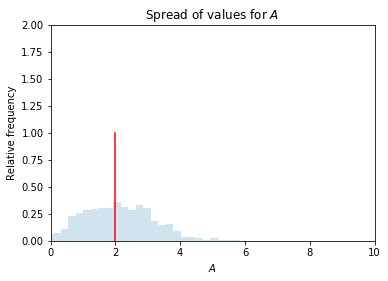

In [41]:
# Build the canvas again
fig, ax = make_my_figure(10,2)

# Histogram the y-intercepts
ax.hist(results[:,1], bins=int(np.size(results[:,0])/30), alpha=0.2, density=True)

ax.plot([p0[0],p0[0]],[0,1],'-r')

ax.set_title('Spread of values for $A$')
ax.set_xlabel('$A$')
ax.set_ylabel('Relative frequency')

Text(0, 0.5, 'Relative frequency')

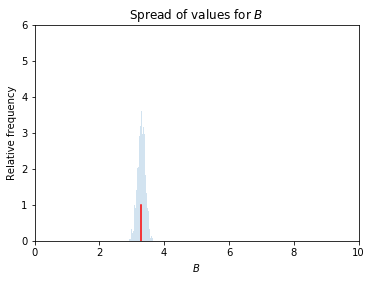

In [42]:
# Build the canvas again
fig, ax = make_my_figure(10,6)

# Histogram the slopes
ax.hist(results[:,2], bins=int(np.size(results[:,0])/30), alpha=0.2, density=True)

ax.plot([p0[1],p0[1]],[0,1],'-r')

ax.set_title('Spread of values for $B$')
ax.set_xlabel('$B$')
ax.set_ylabel('Relative frequency')